<a href="https://colab.research.google.com/github/jasmitha-adari/G_classification/blob/main/week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Define the correct dataset path (update if you renamed folder)
dataset_path = '/content/drive/MyDrive/Datasets/Untitled folder/archive/TrashType_Image_Dataset'
print(os.listdir(dataset_path)[:10])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['trash', 'paper', 'glass', 'metal', 'plastic', 'cardboard']


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
dataset_path = '/content/drive/MyDrive/Datasets/Untitled_folder/archive/TrashType_Image_Dataset'


In [11]:
import os
print(os.listdir(dataset_path)[:10])


['trash', 'paper', 'glass', 'metal', 'plastic', 'cardboard']


In [13]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [18]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=35)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [21]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
dataset_path = '/content/drive/MyDrive/Datasets/Untitled folder/archive/TrashType_Image_Dataset'
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)
val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)
class_names = train_ds.class_names
print(class_names)


Found 2547 files belonging to 6 classes.
Using 2038 files for training.
Found 2547 files belonging to 6 classes.
Using 509 files for validation.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [25]:
test_path = '/content/drive/MyDrive/Datasets/Untitled folder/archive/TrashType_Image_Dataset'

test_ds = image_dataset_from_directory(
    test_path,
    image_size=(256, 256),
    batch_size=32,
    shuffle=False
)



Found 2547 files belonging to 6 classes.


In [27]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.05, 'glass': 19.48, 'metal': 16.44, 'paper': 23.16, 'plastic': 19.53, 'trash': 5.35}
{'cardboard': 16.9, 'glass': 20.43, 'metal': 14.73, 'paper': 23.97, 'plastic': 18.47, 'trash': 5.5}
{'cardboard': 16.22, 'glass': 19.67, 'metal': 16.1, 'paper': 23.32, 'plastic': 19.32, 'trash': 5.38}
{'cardboard': 16.48, 'glass': 19.95, 'metal': 15.59, 'paper': 23.56, 'plastic': 19.0, 'trash': 5.42}


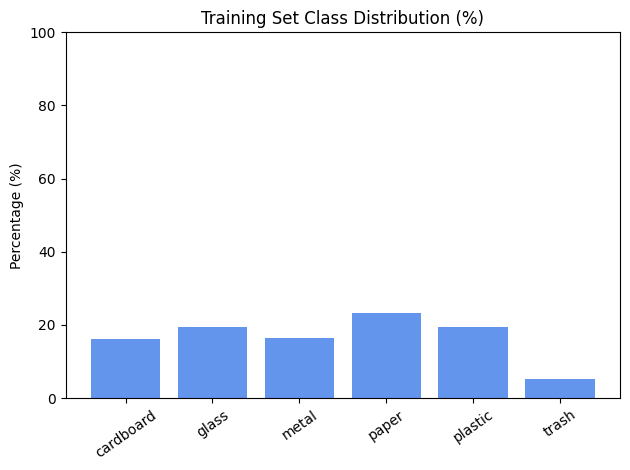

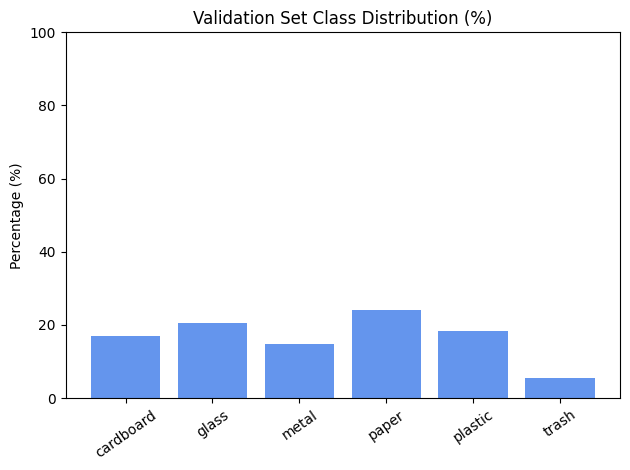

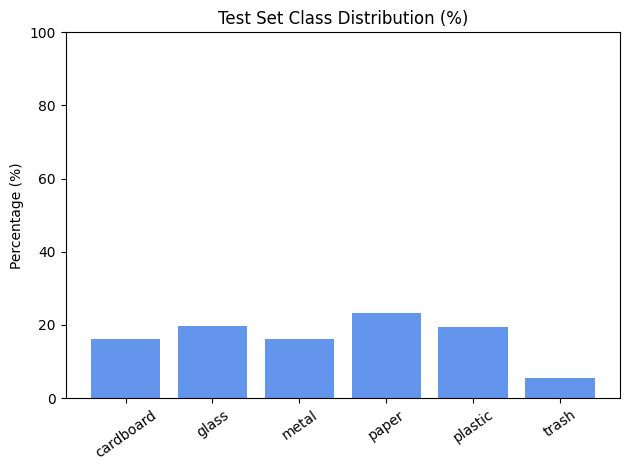

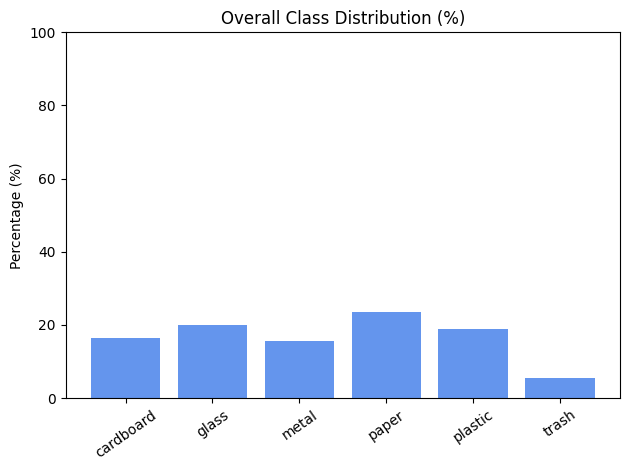

In [31]:
import matplotlib.pyplot as plt
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")


In [33]:
# Count class occurrences and prepare label list
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [35]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 327, 1: 397, 2: 335, 3: 472, 4: 398, 5: 109}
Class Weights: {0: np.float64(1.0387359836901122), 1: np.float64(0.855583543240974), 2: np.float64(1.0139303482587065), 3: np.float64(0.719632768361582), 4: np.float64(0.8534338358458962), 5: np.float64(3.1162079510703364)}


In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [39]:
# Import the model
from tensorflow.keras.applications import EfficientNetV2B2

# Load the pretrained EfficientNetV2B2 model
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(124, 124, 3),
    include_preprocessing=True,
    weights='imagenet'
)

# Freeze first 100 layers (optional tuning)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [47]:

import tensorflow as tf
from tensorflow.keras import layers, Sequential, optimizers
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


dataset_path = '/content/drive/MyDrive/Datasets/Untitled folder/archive/TrashType_Image_Dataset'


train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(256, 256),  # Match model input size
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(256, 256),
    batch_size=32
)


class_names = train_ds.class_names
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for _, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}


data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(256, 256, 3),
    include_preprocessing=True,
    weights='imagenet'
)

# Freeze early layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


model = Sequential([
    layers.Input(shape=(256, 256, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early],
    class_weight=class_weights
)



Found 2547 files belonging to 6 classes.
Using 2038 files for training.
Found 2547 files belonging to 6 classes.
Using 509 files for validation.
Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 735s 10s/step - accuracy: 0.3975 - loss: 1.5831 - val_accuracy: 0.8055 - val_loss: 0.8574
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 674s 10s/step - accuracy: 0.7965 - loss: 0.7810 - val_accuracy: 0.8546 - val_loss: 0.4884
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 663s 10s/step - accuracy: 0.8563 - loss: 0.4640 - val_accuracy: 0.8939 - val_loss: 0.3463
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 659s 10s/step - accuracy: 0.9205 - loss: 0.2669 - val_accuracy: 0.9116 - val_loss: 0.2823
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 633s 10s/step - accuracy: 0.9446 - loss: 0.1885 - val_accuracy: 0.9116 - val_loss: 0.2595


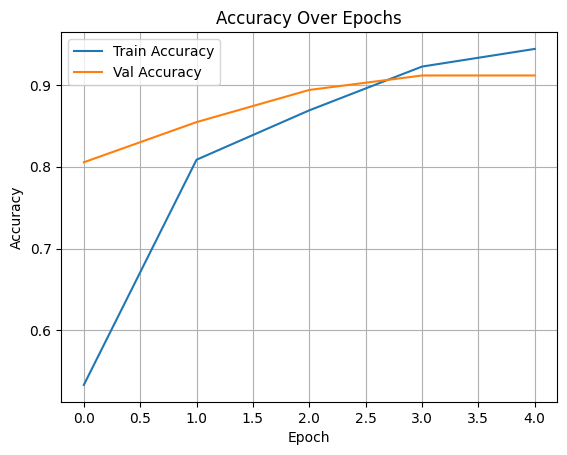

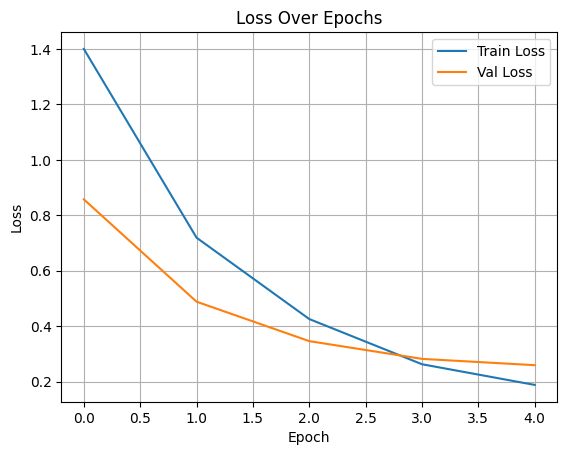

In [48]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
